# Using TensorFlow with Jetscape Benchmarck Dataset
**About the JETSCAPE Eloss Classification dataset**.   
Jetscape Eloss Classification is the equivalent *Hello World* of jet image analysis.
It consists of 4 categories, MATTER-VACCUUM/MATTER-MEDIUM/MATTER+LBT/MATTER+MARTINI, in 32x32 pixel squares.  
Each gray-scale pixel contains an integer 0-255 to indicate darkness, with 0 white and 255 black.  
There are about 180,000 training records, and about 20,000 test records.  
In other words, the images of numbers have already been transformed into arrays of ints to make them easier to use for ML projects. You can find more info on the jetscape [here](https://jetscape.org/). You can also download it from [here](#).


## Part 0: Prerequisites:

We recommend that you run this this notebook in the cloud on Google Colab (see link with icon at the top) if you're not already doing so. It's the simplest way to get started. You can also [install TensorFlow locally](https://www.tensorflow.org/install/).

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report

# Commonly used modules
import numpy as np
import os
import sys
import time

# Images, plots, display, and visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import cv2
import IPython
from six.moves import urllib

print(tf.__version__)
sys.version_info
!python --version

2.8.0
Python 3.7.12


## 1. Load Data into a Numpy Array  
I downloaded the data file onto my desktop and loaded it locally.  
You can also load it directly from the cloud as follows:  
```mnist = tf.keras.datasets.mnist  
(x_train, y_train), (x_test, y_test) = jetscapeMl.load_data()  
```  
**After the load:**   
x_train contains 180k arrays of 32x32.  
The y_train vector contains the corresponding labels for these.  
x_test contains 20k arrays of 32x32.  
The y_test vector contains the corresponding labels for these.

**Building Randomized Dataset**
Before having the simulation data, researcher tried to implmenet a psudo random data to create the architecture for the project. I thought it could be useful for further usages.

In [3]:
def dataset_y_builder(y_size,y_class_label_items):
    class_size=int(y_size/len(y_class_label_items))
    y=[]
    for class_label_item in y_class_label_items:
        y = np.append (y, [class_label_item]*class_size)
    return y

def dataset_x_builder_randomized(x_size,dataset_frame_size):
    x=np.arange(x_size*dataset_frame_size*dataset_frame_size)\
    .reshape((x_size,dataset_frame_size,dataset_frame_size))
    return x

def build_randomized_dataset():
  dataset_frame_size=32
  #train_size=600
  #test_size=100
  train_size=1600
  test_size=400

  y_class_label_items=['MVAC','MMED','MLBT','MMAR']
  y_train=dataset_y_builder(train_size,y_class_label_items)
  y_test=dataset_y_builder(test_size,y_class_label_items)


  x_train=dataset_x_builder_randomized(train_size,dataset_frame_size)
  x_test=dataset_x_builder_randomized(test_size,dataset_frame_size)

  print(type(x_train), x_train.size, x_train.shape)
  print(type(y_train), y_train.size, y_train.shape)
  print(type(x_test), x_test.size, x_test.shape)
  print(type(y_test), y_test.size, y_test.shape)
  dataset=((x_train, y_train), (x_test, y_test))
  return dataset

##Saving and Loading Dataset 

In [4]:
import pickle
def save_dataset(file_name,dataset):
    with open(file_name, 'wb') as dataset_file:
        pickle.dump(dataset,dataset_file, protocol=pickle.HIGHEST_PROTOCOL)

        
!pip3 install pickle5
import pickle5 as pickle

def load_dataset(file_name):
    with open(file_name, 'rb') as dataset_file:
        (x_train, y_train), (x_test, y_test) = pickle.load(dataset_file, encoding='latin1')
        dataset=((x_train, y_train), (x_test, y_test))
        return dataset

     |████████████████████████████████| 256 kB 23.5 MB/s 


##Suffling the dataset and Saving the shuffling result
Shuffle function doesn't work in this case, because we need to change both x, and y array together. Therefore, take function is used to make a random permutation. For shuffling the x data, the axis shall be mentioned, so it will shuffle over the first dimension.


---
1. Shuffling Train Dataset
2. Shuffling Test Dataset


In [5]:
def shuffle_training_dataset(x_train, y_train):
  
  print("Train Dataset Permutation Array:")
  train_permutation_array_indices=np.random.permutation(y_train.size)
  #print(train_permutation_array_indices[1:100])

  print("y_train:")
  print(y_train, type(y_train),y_train.size, y_train.shape)
  #print(y_train[1:100])

  print("y_train_shuffled:")
  y_train_shuffled=np.take(y_train, train_permutation_array_indices)
  print(y_train_shuffled, type(y_train_shuffled),y_train_shuffled.size, y_train_shuffled.shape)
  #print(y_train_shuffled[1:100])

  print("x_train:")
  print(x_train, type(x_train),x_train.size, x_train.shape)
  #print(x_train[1:100])

  print("x_train_shuffled:")
  x_train_shuffled=np.take(x_train, train_permutation_array_indices,axis=0)
  print(x_train_shuffled, type(x_train_shuffled),x_train_shuffled.size, x_train_shuffled.shape)
  #print(x_train_shuffled[1:100])

  dataset_train_shuffled=(x_train_shuffled, y_train_shuffled)
  return dataset_train_shuffled


#main method

def shuffle_training_dataset_runner():
  from google.colab import drive
  drive.mount('/content/drive')
  dataset_directory_path='/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

  #file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'


  start_time = time.time()

  #file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k.pkl'
  file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000.pkl'
  # file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
  dataset_path=dataset_directory_path+file_name;

  (x_train, y_train), (x_test, y_test) =load_dataset(dataset_path)

  (x_train_shuffled, y_train_shuffled)=shuffle_training_dataset(x_train, y_train)

  #file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-03.pkl'
  file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000-shuffled.pkl'
  # file_name='jetscape-ml-benchmark-dataset-2k-randomized-shuffled.pkl'
  shuffled_dataset_path=dataset_directory_path+file_name
  dataset=((x_train_shuffled,y_train_shuffled),(x_test,y_test))
  save_dataset(shuffled_dataset_path,dataset)
  end_time=time.time()

  elapsed_time=end_time-start_time
  print('Elapsed Time: ')
  print(elapsed_time)

**Saving Dataset Benchmark as a file**

In [6]:
def save_dataset_runner():
  #file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'
  file_directory_path= '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

  file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
  dataset=((x_train,y_train),(x_test,y_test))
  save_dataset(file_directory_path+file_name,dataset)

**Creatinng a random event and demostrate it in a 2-D histogram**
This module implemented for developemental purpose, just as an example of how the events can be shown in 2-D images with their hit frequency

In [7]:
def create_and_plot_random_event():
  pi=3.14
  current_event_hits=np.random.uniform(-pi, pi, size=(2, 10000))
  counts, xedges, yedges = np.histogram2d(current_event_hits[0], current_event_hits[1], bins=32)
  print(counts)
  #plt.imshow(counts.reshape(32, 32), cmap=cm.Greys)
  plt.imshow(counts, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  cb = plt.colorbar()
  cb.set_label("Hit Frequency")
  return counts
# Funtionality Testing
# counts=create_and_plot_random_event()
# save_dataset('sampleRandomEventHistogram32x32.pkl',counts)

## 2. Use Matplotlib to visualize one record.  
I set the colormap to Grey and ColorMap. There are a bunch of other colormap choices if you like bright visualizations. Try magma or any of the other  choice in the [docs](https://matplotlib.org/tutorials/colors/colormaps.html).

In [8]:
def plot_event(image_frame_size,event_matrix):
  plt.imshow(event_matrix.reshape(image_frame_size, image_frame_size), cmap=cm.Greys)
  cb = plt.colorbar()
  cb.set_label("Hit Frequency")

# image_frame_size=32
# plot_event(image_frame_size,x_train[55])

In [24]:
class JetscapeMlCnn:
   # class attribute
  
    # Instance attribute
    def __init__(self, x_train,y_train,x_test,y_test):
        self.x_train=x_train
        self.y_train=y_train
        self.x_test=x_test
        self.y_test=y_test


#Loading Dataset Phase
from google.colab import drive
drive.mount('/content/drive')
file_directory_path= '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

#file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'

#file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
# file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000.pkl'
file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-01.pkl'

(x_train, y_train), (x_test, y_test) =load_dataset(file_directory_path+file_name)

oJetscapeMlCnn=JetscapeMlCnn(x_train, y_train, x_test, y_test)

print("Post-Load: DataType Checkpoint: Begin")
print(type(oJetscapeMlCnn.x_train), oJetscapeMlCnn.x_train.size, oJetscapeMlCnn.x_train.shape)
print(type(oJetscapeMlCnn.y_train), oJetscapeMlCnn.y_train.size, oJetscapeMlCnn.y_train.shape)
print(type(oJetscapeMlCnn.x_test), oJetscapeMlCnn.x_test.size, oJetscapeMlCnn.x_test.shape)
print(type(oJetscapeMlCnn.y_test), oJetscapeMlCnn.y_test.size, oJetscapeMlCnn.y_test.shape)
print(oJetscapeMlCnn.y_train[1500], oJetscapeMlCnn.y_test[99])
print(oJetscapeMlCnn.y_train[1:500])
print("Post-Load: DataType Checkpoint: End")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Post-Load: DataType Checkpoint: Begin
<class 'numpy.ndarray'> 184320000 (180000, 32, 32)
<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20480000 (20000, 32, 32)
<class 'numpy.ndarray'> 20000 (20000,)
MVAC MVAC
['MLBT' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MVAC' 'MLBT'
 'MVAC' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MLBT'
 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT'
 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MLBT'
 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT'
 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT' 'MLBT' 'MLBT'
 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MVAC'
 'MVAC' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT' 'MLBT' 'MLBT'
 'MLBT' 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MVAC' 'MVAC'
 'MV

## 3. Plot a bunch of records to see sample data  
Basically, use the same Matplotlib commands above in a for loop to show 20 records from the train set in a subplot figure. We also make the figsize a bit bigger and remove the tick marks for readability.
** TODO: try to make the subplot like the below image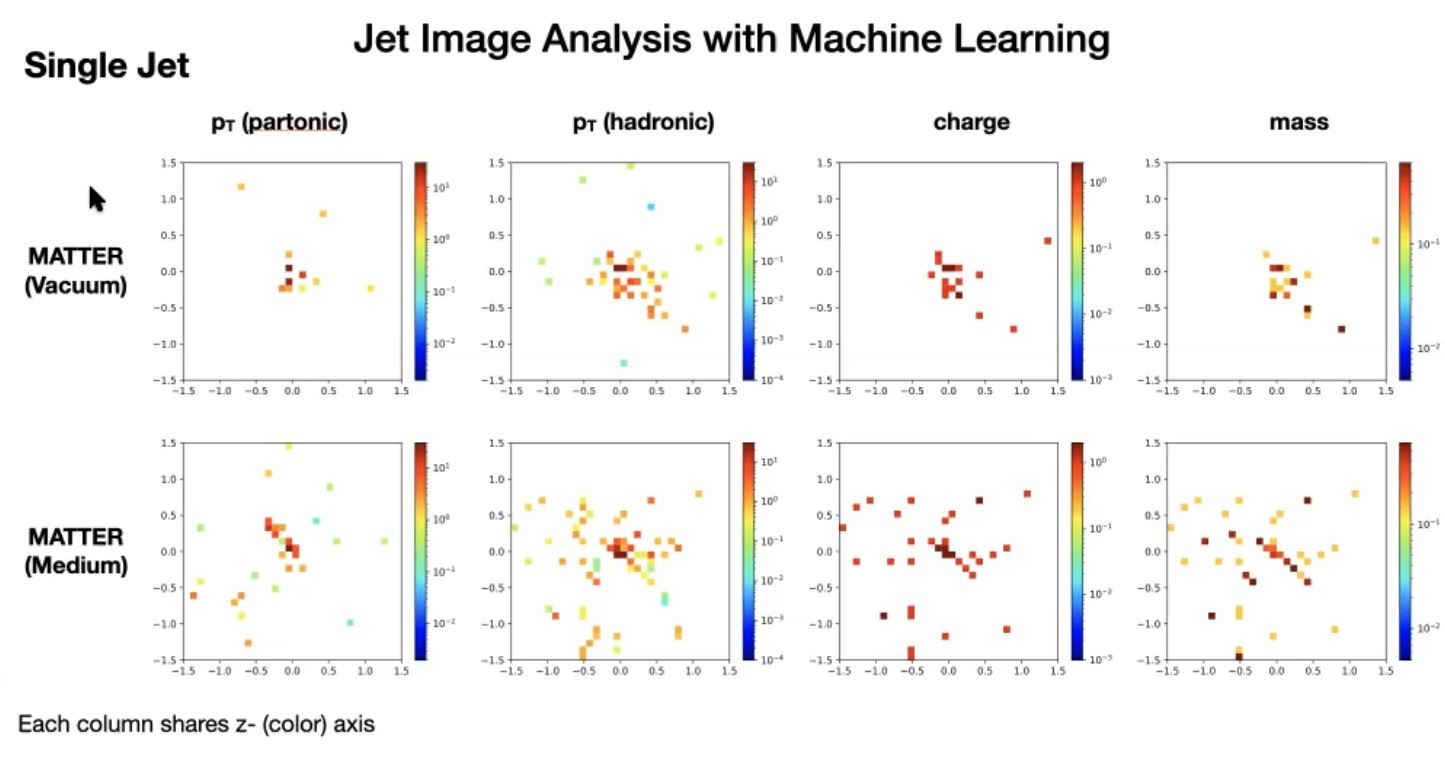



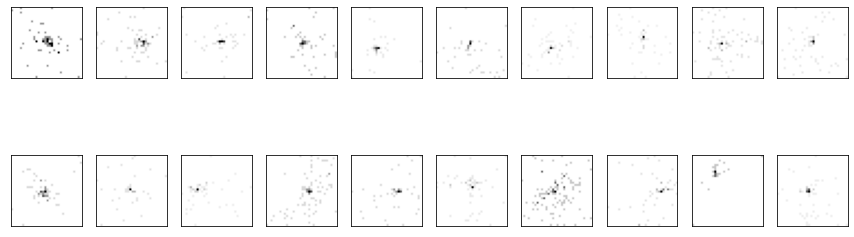

In [16]:
def plot_20_sample_events(events_matrix_items):
  # images = x_train[0:18]
  # fig, axes = plt.subplots(3, 6, figsize=[9,5])
  images = events_matrix_items
  fig, axes = plt.subplots(2, 10, figsize=[15,5])

  for i, ax in enumerate(axes.flat):
      current_plot= ax.imshow(x_train[i].reshape(32, 32), cmap=cm.Greys)
      ax.set_xticks([])
      ax.set_yticks([])     
  plt.show

#Plotting 20 Sample Events Phase
events_matrix_items=[x_train[0:10],x_train[1500:10]]
plot_20_sample_events(events_matrix_items)

## 4. Show distribution of training data labels   
The training data is about evenly distributed across all nine digits. 

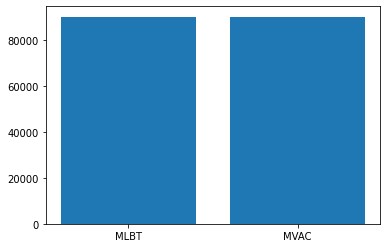

[90000 90000]
['MLBT' 'MVAC']
['MLBT' 'MVAC']
[0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0]


In [25]:
def plot_y_train_dataset_distribution(y_train):
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)


  counts = np.bincount(positions)
  plt.bar(unique_class_labels, counts)
  plt.show()
  print(counts)
  print(unique_class_labels)
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)
  print(unique_class_labels)
  print(positions[1:20])

#Checking Train Dataset Y Distribution
plot_y_train_dataset_distribution(y_train)

# Changing classification labels from Literal to Numeric

---



In [26]:
def convertDatasetYFromLiteralToNumeric(y_dataset):
  y_train=y_dataset[0]
  y_test=y_dataset[1]
  y_train_unique_class_labels,y_train_positions = np.unique(y_train,return_inverse=True)
  y_test_unique_class_labels,y_test_positions = np.unique(y_test,return_inverse=True)

  print(type(y_train), y_train.size, y_train.shape)
  print(type(y_test), y_test.size, y_test.shape)
  print(type(y_train[0]))
  print(type(y_test[0]))

  print(y_train_unique_class_labels)
  print(y_test_unique_class_labels)
  y_train=y_train_positions
  y_test=y_test_positions
  print(type(y_train), y_train.size, y_train.shape)
  print(type(y_test), y_test.size, y_test.shape)

  print(type(y_train[0]))
  print(type(y_test[0]))
  return ((y_train,y_test))
y_train,y_test =convertDatasetYFromLiteralToNumeric((y_train,y_test))

<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.str_'>
<class 'numpy.str_'>
['MLBT' 'MVAC']
['MLBT' 'MVAC']
<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.int64'>
<class 'numpy.int64'>


## Normalizing the Dataset X
For training the model, the dataset needs to be normalized, meaning all of the dataset values should me between zero and one. This can be done by finding the maximum values over the dataset X side values and devide all the element by it.

In [27]:
def calculate_dataset_x_max_value(x_dataset):
  x_train=x_dataset[0]
  x_test=x_dataset[1]
  max_x=np.amax([np.amax(x_train), np.amax(x_test)])
  return max_x

def normalize_dataset_x_value_range_between_0_and_1(x_dataset,max_x):
  x_train=x_dataset[0]
  x_test=x_dataset[1]

  # Normalize the data to a 0.0 to 1.0 scale for faster processing
  x_train, x_test = x_train / max_x, x_test / max_x
  return (x_train, x_test)


#Normalizing Phase
x_dataset=(x_train,x_test)
max_x=calculate_dataset_x_max_value(x_dataset)
x_train,x_test=normalize_dataset_x_value_range_between_0_and_1(x_dataset,max_x)

image_frame_size=32

print("Normalizing Dataset X: maximum hit frequency in the dataset: ")
print(max_x)


Normalizing Dataset X: maximum hit frequency in the dataset: 
20.0


##Defining Validation Dataset from Train Dataset

In [28]:
# Reserve 20% samples for validation dataset
def calculate_validation_dataset_size(dataset_train_size,dataset_test_size):
  dataset_size= dataset_train_size+dataset_test_size
  dataset_validation_size=dataset_size*.2
  return int(dataset_validation_size)

def set_validation_dataset(x_train,y_train,validation_dataset_size):
  
  x_val = x_train[-validation_dataset_size:]
  y_val = y_train[-validation_dataset_size:]
  x_train = x_train[:-validation_dataset_size]
  y_train = y_train[:-validation_dataset_size]
  
  print(type(y_train), y_train.size, y_train.shape)
  print(type(x_train), x_train.size, x_train.shape)

  print(type(y_val), y_val.size, y_val.shape)
  print(type(x_val), x_val.size, x_val.shape)

  print(type(y_test), y_test.size, y_test.shape)
  print(type(x_test), x_test.size, x_test.shape)
  return (x_train, y_train), (x_val, y_val)

validation_dataset_size= calculate_validation_dataset_size(y_train.size,y_test.size)
(x_train, y_train), (x_val, y_val)=set_validation_dataset(x_train,y_train,validation_dataset_size)

<class 'numpy.ndarray'> 140000 (140000,)
<class 'numpy.ndarray'> 143360000 (140000, 32, 32)
<class 'numpy.ndarray'> 40000 (40000,)
<class 'numpy.ndarray'> 40960000 (40000, 32, 32)
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.ndarray'> 20480000 (20000, 32, 32)


## 5.2 Apply Keras/TensorFlow CNN

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 128)       

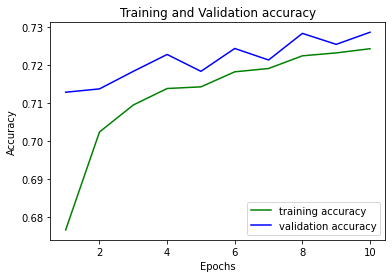

Elapsed 1793.897 seconds.


In [29]:
# import tensorflow as tf


# from tensorflow import keras
# from keras_preprocessing import image
# from keras_preprocessing.image import ImageDataGenerator

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(image_frame_size,image_frame_size,1)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    # tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

model.summary()

model.compile(optimizer=tf.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['acc'])



print("Fit model on training data")
# fit(object, x = NULL, y = NULL, batch_size = NULL, epochs = 10,
#   verbose = getOption("keras.fit_verbose", default = 1),
#   callbacks = NULL, view_metrics = getOption("keras.view_metrics",
#   default = "auto"), validation_split = 0, validation_data = NULL,
#   shuffle = TRUE, class_weight = NULL, sample_weight = NULL,
#   initial_epoch = 0, steps_per_epoch = NULL, validation_steps = NULL,
#   ...)
# -> object : the model to train.      
# -> X : our training data. Can be Vector, array or matrix      
# -> Y : our training labels. Can be Vector, array or matrix       
# -> Batch_size : it can take any integer value or NULL and by default, it will
# be set to 32. It specifies no. of samples per gradient.      
# -> Epochs : an integer and number of epochs we want to train our model for.      
# -> Verbose : specifies verbosity mode(0 = silent, 1= progress bar, 2 = one
# line per epoch).      
# -> Shuffle : whether we want to shuffle our training data before each epoch.      
# -> steps_per_epoch : it specifies the total number of steps taken before
# one epoch has finished and started the next epoch. By default it values is set to NULL.

start_time =time.perf_counter()

no_epoch=10
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=no_epoch,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val))

model.save('matter_vs_matterlbt_2k.h5')
acc_train = history.history['acc']
acc_val = history.history['val_acc']
print(acc_train)
print(acc_train)
epochs = range(1,no_epoch+1)
plt.plot(epochs,acc_train, 'g', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

elapsed_time=time.perf_counter() - start_time
print('Elapsed %.3f seconds.' % elapsed_time)

## Previous research replication


In [30]:
## event info
collision = 'PbPb'
energy = 5020
centrality = '0_10'
Modules = ['PP19','LBT']
JetptMinMax = '100_110'
#observables = ['pt','charge','mass']
observables = ['pt']
kind = 'Hadron'

In [32]:
## create a directory to save the best model
from os import path, makedirs
from google.colab import drive
drive.mount('/content/drive')
# file_directory_path= '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

save_dir = '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/models/Models_{}_vs_{}_{}_ch{}'.format(Modules[0], Modules[1], kind, len(observables))
if not path.exists(save_dir):
    makedirs(save_dir)
print('Directory to save models: {}'.format(save_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory to save models: /content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/models/Models_PP19_vs_LBT_Hadron_ch1


In [71]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad


def get_callbacks(monitor, save_dir):
    mode = None
    if 'loss' in monitor:
        mode = 'min'
    elif 'accuracy' in monitor:
        mode = 'max'
    assert mode != None, 'Check the monitor parameter!'

    es = EarlyStopping(monitor=monitor, mode=mode, patience=10,
                      min_delta=0., verbose=1)
    rlp = ReduceLROnPlateau(monitor=monitor, mode=mode, factor=0.2, patience=5,
                            min_lr=0.001, verbose=1)
    mcp = ModelCheckpoint(path.join(save_dir, 'best_model.h5'), monitor=monitor, 
                          save_best_only=True, mode=mode, verbose=1)
    
    return [es, rlp, mcp]

def conv2d_layer_block(prev_layer, filters, dropout_rate, input_shape=None):
    if input_shape != None:
        prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02),
                              input_shape=input_shape
                             )
                      )
    else:
        prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02),
                             )
                      )
    prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02)
                             )
                      )    
    prev_layer.add(MaxPool2D(pool_size=(2, 2)))
    prev_layer.add(Dropout(dropout_rate))
    
    return prev_layer

def fc_layer_block(prev_layer, units, dropout_rate, last_layer=False):
    if last_layer == False:
        prev_layer.add(Dense(units, activation='relu',
                             kernel_initializer='he_uniform',
                             kernel_regularizer=l2(l=0.02)
                            )
                      )
        prev_layer.add(Dropout(dropout_rate))
    else:
        prev_layer.add(Dense(1, activation='sigmoid'))

    return prev_layer

def CNN_model(input_shape, lr, dropout1, dropout2):
    model = Sequential()
    model = conv2d_layer_block(model, 256, dropout1, input_shape)
    model = conv2d_layer_block(model, 256, dropout1)
    model = conv2d_layer_block(model, 256, dropout1)
    model = conv2d_layer_block(model, 256, dropout1)
    #model = conv2d_layer_block(model, 128, dropout1)
    model.add(Flatten())
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1, None, last_layer=True)
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

In [73]:
print(x_train.shape)
print (x_train.shape[0],x_train.shape[1],x_train.shape[2])
x_train_reshaped=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
print(x_train_reshaped.shape)

print(x_val.shape)
print (x_val.shape[0],x_val.shape[1],x_val.shape[2])
x_val_reshaped=x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
print(x_train_reshaped.shape)

print(x_test.shape)
print (x_test.shape[0],x_test.shape[1],x_test.shape[2])
x_test_reshaped=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
print(x_test_reshaped.shape)


(140000, 32, 32)
140000 32 32
(140000, 32, 32, 1)
(40000, 32, 32)
40000 32 32
(140000, 32, 32, 1)
(20000, 32, 32)
20000 32 32
(20000, 32, 32, 1)


In [80]:
## parameers for training
# n_epochs = 30
n_epochs=2
batch_size = 256
input_shape = x_train_reshaped.shape[1:]
monitor='val_accuracy' #'val_accuracy' or 'val_loss'
lr = 5e-6
dropout1, dropout2 = 0.2, 0.2

In [83]:
from time import time
def train_network(train_set, val_set, n_epochs, lr, batch_size, monitor):
    tf.keras.backend.clear_session()
    X_train = train_set[0]
    Y_train = train_set[1]
    model = CNN_model(input_shape, lr, dropout1, dropout2)
    callbacks = get_callbacks(monitor, save_dir)
    
    model.summary()
    
    start = time()
    history = model.fit(X_train, Y_train, epochs=n_epochs, verbose=1, batch_size=batch_size, 
                        validation_data=val_set, shuffle=True, callbacks=callbacks)

    train_time = (time()-start)/60.
    return history, train_time

In [ ]:
# training and validation sets
train_set, val_set = (x_train_reshaped, y_train), (x_val_reshaped, y_val)

# train the network
history, train_time = train_network(train_set, val_set, n_epochs, lr, batch_size, monitor)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       6656      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       1638656   
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       1638656   
                                                        

In [ ]:
from matplotlib import pyplot as plt
def plot_train_history(history):

    color_list = ['red','blue','black','green']

    plt.figure(figsize=(8, 2.5), dpi=100)

    plt.subplot(121)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.title('Loss history')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy history')
    plt.legend()

In [ ]:
# plot the training history for each fold
plot_train_history(history)

In [ ]:
from tensorflow.keras.models import load_model
## load the best model
best_model = load_model(path.join(save_dir,'best_model.h5'))

print('Train   | Validation | Test sets')

## evaluate the model on train/val/test sets and append the results to lists
_, train_acc = best_model.evaluate(x_train_reshaped, y_train, verbose=0)
_, val_acc = best_model.evaluate(x_val_reshaped, y_val, verbose=0)
_, test_acc = best_model.evaluate(x_test_reshaped, y_test, verbose=0)
    
## print out the accuracy
print('{:.4f}%  {:.4f}%     {:.4f}%'.format(train_acc * 100, val_acc * 100, test_acc * 100))

In [ ]:
## plot confution matrix
y_pred = best_model.predict_classes(x_test_reshaped)

conf_mat = confusion_matrix(y_pred, y_test)
sns.heatmap(conf_mat, annot=True, cmap='Blues', 
            xticklabels=Modules, yticklabels=Modules, fmt='g')
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.show()

#Validation Phase

In [ ]:
hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch
# hist['rmse']=np.sqrt( hist.loss)
hist['accuracy']=np.sqrt( hist.accuracy)

print(hist)
print("Mean Training Accuracy", np.mean(hist.accuracy))
# rmse_final = np.sqrt(float(hist['loss']))
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Mean Square Error')
    plt.ylabel('Loss(Blue)/Accuracy(Orange)')
    plt.plot(hist['epoch'], hist['loss'], label='loss')
    plt.plot(hist['epoch'], hist['accuracy'], label='accuracy')
    # plt.plot(hist['epoch'], hist['rmse'], label = 'RMSE')
    plt.legend()
    plt.ylim([0,1])

plot_history()

#Binary Classification Results


Classification                      | #epoch | Hadron \begin{pmatrix} p_{T} \end{pmatrix}
-------------------                 |--------|------------------
MATTER (in-medium) v.s. MATTER+LBT  |500| 95.88%
 

#Precision - Recall - F1Score

$precision= \frac{true \: positive}{true \: positive \: + \:false \: positive}$

$recal= \frac{true \: positive}{true \: positive \: + \: false \: negative}$

$f1-score= \frac{2}{precision^{-1} \: + \: recall^{-1}}$

In [ ]:

# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
def calcualte_precision_recall_f1score_confision_matrix():
  prediction=model.predict(x_test)
  prediction=[ 1 if current_y_test>0.5 else 0 for current_y_test in prediction ]
  #checking if prediction vector is binary
  truth=y_test
  cm = confusion_matrix(truth,prediction)
  print_confusion_matrix(cm,["MATTER","MATTER-LBT"])
  print(classification_report(truth, prediction))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57     10000
           1       0.51      0.36      0.42     10000

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.50     20000
weighted avg       0.51      0.51      0.50     20000



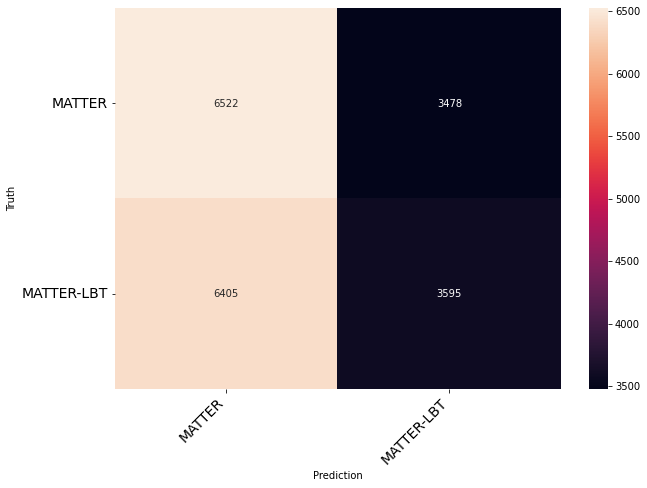

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [ ]:
from sklearn import metrics
def calcualte_mse(x_test):

  # Predict
  pred = model.predict(x_test)
  # Measure MSE error.  
  mse = metrics.mean_squared_error(pred,y_test)
  print("Final score (MSE): {}".format(mse))
  rmse = np.sqrt(mse)
  print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))


Final score (MSE): 0.3986714993310698
Root Mean Square Error on test set: 0.631


### Evaluate accuracy

To predict new values, the Neural Network uses classifier.predict. I'm going to pass it the test values for x_test (which the Neural Network hasn't previously seen) and it will give me back a set of predictions. These predicitons will be probabilities, so I will clean them up by saying that if thye are greater than .5, I'll make them 1, else I'll make them 0.
Next, compare how the model performs on the test dataset:


In [1]:
def calculate_test_loss_and_accuracy(x_test,):
  y_test_prediction=model.predict(x_test)

  y_test_prediction = [ 1 if y_test>0.5 else 0 for y_test in y_test_prediction ]
  print(y_test_prediction)
  total = 0
  correct = 0
  wrong = 0
  for i in y_test_prediction:
    total=total+1
    if(y_test[i] == y_test_prediction[i]):
      correct=correct+1
    else:
      wrong=wrong+1

  print("Total " + str(total))
  print("Correct " + str(correct))
  print("Wrong " + str(wrong))
  print(correct/total)
  print(wrong/total)

  test_loss, test_acc = model.evaluate(x_test, y_test)
  return (test_loss,test_acc)

NameError: ignored

Often times, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. In our case, the accuracy is better at 60.5. This is, in part, due to successful regularization accomplished with the Dropout layers.

### Make predictions

With the model trained, we can use it to make predictions about some events. Let's step outside the dataset for that and go with the beautiful high-resolution images generated by a real world expiremental dataset.

In [ ]:
# import cv2
# mnist_dream_path = 'images/mnist_dream.mp4'
# mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# # download the video if running in Colab
# if not os.path.isfile(mnist_dream_path): 
#     print('downloading the sample video...')
#     vid_url = this_tutorial_url + '/' + mnist_dream_path
    
#     mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
# def cv2_imshow(img):
#     ret = cv2.imencode('.png', img)[1].tobytes() 
#     img_ip = IPython.display.Image(data=ret)
#     IPython.display.display(img_ip)
# def cap_read(frame):
#     img= x_test[frame-1]
#     if img is not None:
#       ret=True
#     else:
#       ret=False
#     return ret, img 
# # cap = cv2.VideoCapture(mnist_dream_path) 
# cap = x_test[100:300]
# vw = None
# frame = -1 # counter for debugging (mostly), 0-indexed

# # go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
# while True: # should 481 frames
#     frame += 1
#     # ret, img = cap.read()
#     ret, img = cap.read(frame)
#     if not ret: break
               
#     assert img.shape[0] == img.shape[1] # should be a square
#     if img.shape[0] != 32:
#         img = cv2.resize(img, (32, 32))
       
#     #preprocess the image for prediction
#     img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img_proc = cv2.resize(img_proc, (32, 32))
#     img_proc = preprocess_images(img_proc)
#     img_proc = 1 - img_proc # inverse since training dataset is white text with black background

#     net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
#     net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
#     preds = model.predict(net_in)[0]
#     guess = np.argmax(preds)
#     perc = np.rint(preds * 100).astype(int)
    
#     img = 255 - img
#     pad_color = 0
#     img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
#     line_type = cv2.LINE_AA
#     font_face = cv2.FONT_HERSHEY_SIMPLEX
#     font_scale = 1.3        
#     thickness = 2
#     x, y = 740, 60
#     color = (255, 255, 255)
    
#     text = "Neural Network Output:"
#     cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
#                     color=color, lineType=line_type)
    
#     text = "Input:"
#     cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
#                     color=color, lineType=line_type)   
        
#     y = 130
#     for i, p in enumerate(perc):
#         if i == guess: color = (255, 218, 158)
#         else: color = (100, 100, 100)
            
#         rect_width = 0
#         if p > 0: rect_width = int(p * 3.3)
        
#         rect_start = 180
#         cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

#         text = '{}: {:>3}%'.format(i, int(p))
#         cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
#                     color=color, lineType=line_type)
#         y += 60
    
#     # if you don't want to save the output as a video, set this to False
#     save_video = True
    
#     if save_video:
#         if vw is None:
#             codec = cv2.VideoWriter_fourcc(*'DIVX')
#             vid_width_height = img.shape[1], img.shape[0]
#             vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
#         # 15 fps above doesn't work robustly so we right frame twice at 30 fps
#         vw.write(img)
#         vw.write(img)
    
#     # scale down image for display
#     img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
#     cv2_imshow(img_disp)
#     IPython.display.clear_output(wait=True)
        
# cap.release()
# if vw is not None:
#     vw.release()

14.0